In [1]:
import numpy as np
from numpy import cos,sin,pi
from scipy.interpolate import interp2d
from numpy.random import random,randint,choice,sample
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from time import time
import cv2

In [2]:
# Dense image warp from Tensorflow addons
# There is an error using tfa.image.dense_image_warp
# define same tfa.image.dense_image_warp

from tensorflow_addons.utils import types
from typing import Optional

def _get_dim(x, idx):
    if x.shape.ndims is None:
        return tf.shape(x)[idx]
    return x.shape[idx] or tf.shape(x)[idx]

def dense_image_warp(image: types.TensorLike, displacement: types.TensorLike, name: Optional[str] = None) -> tf.Tensor:
    with tf.name_scope(name or "dense_image_warp"):
        image = tf.convert_to_tensor(image)
        displacement = tf.convert_to_tensor(displacement)
        batch_size, height, width, channels = (
            _get_dim(image, 0),
            _get_dim(image, 1),
            _get_dim(image, 2),
            _get_dim(image, 3),
        )

        # The flow is defined on the image grid. Turn the flow into a list of query
        # points in the grid space.
        grid_x, grid_y = tf.meshgrid(tf.range(width), tf.range(height))
        stacked_grid = tf.cast(tf.stack([grid_y, grid_x], axis=2), displacement.dtype)
        batched_grid = tf.expand_dims(stacked_grid, axis=0)
        query_points_on_grid = batched_grid + displacement
        query_points_flattened = tf.reshape(query_points_on_grid, [batch_size, height * width, 2])
        # Compute values at the query points, then reshape the result back to the
        # image grid.
        interpolated = tfa.image.interpolate_bilinear(image, query_points_flattened)
        interpolated = tf.reshape(interpolated, [batch_size, height, width, channels])
        return interpolated

In [3]:
def img_grad(imgs):
    #central different
    img_x,img_y = tf.image.image_gradients(imgs)
    img_x,img_y = (img_x+tf.roll(img_x,1,1))/2, (img_y+tf.roll(img_y,1,2))/2
    return img_x,img_y
def count_fold_fn(u):
    u = tf.convert_to_tensor(u)
    u_x,u_y = img_grad(u)
    det_u = (u_x[:,:,:,0]+1)*(u_y[:,:,:,1]+1)-u_x[:,:,:,1]*u_y[:,:,:,0]
    return tf.math.count_nonzero(det_u<=0).numpy()
def grid_warp(u,n=48):
    img_shape = u.shape[:-1]
    img = np.zeros(img_shape)
    for i in range(1,n):
        img[img_shape[0]*i//n,:]=1
        img[:,img_shape[0]*i//n]=1
    ex_img = np.expand_dims(np.expand_dims(img,-1),0)
    ex_u = np.expand_dims(u,0)
    warp = tf.squeeze(dense_image_warp(ex_img,ex_u))
    plt.imshow(warp,cmap='gray')
def vector_field(u,n=6):
    J,I = np.meshgrid(np.arange(256),np.arange(256))
    plt.gca().invert_yaxis()
    plt.quiver(J[::n,::n],I[::n,::n],u[::n,::n,1],-u[::n,::n,0],units='xy')

In [4]:
img_shape = 256,256
number_pair = 550

In [5]:
m,n = img_shape
x = np.arange(0,n+1,n/5) #point
y = np.arange(0,m+1,m/5) #point
disp_fields = np.zeros((0,)+img_shape+(2,))
s = time()
C,R = np.meshgrid(np.arange(n)-(n-1)/2,np.arange(m)-(m-1)/2)
while disp_fields.shape[0]<number_pair:
    z1 = (random((y.shape[0],x.shape[0]))-0.5)*(0.1*m) #size
    z2 = (random((y.shape[0],x.shape[0]))-0.5)*(0.1*m) #size
    f1 = interp2d(x, y, z1, kind='cubic')
    f2 = interp2d(x, y, z2, kind='cubic')
    u1 = f1(np.arange(n),np.arange(m))
    u2 = f2(np.arange(n),np.arange(m))
    u = np.stack([u1,u2],axis=-1)
    fold_direct = count_fold_fn(np.expand_dims(u,0))
    fold_inverse = count_fold_fn(np.expand_dims(-u,0))
    #print(fold)
    if fold_direct==0 and fold_inverse==0:
        disp_fields = np.concatenate([disp_fields,np.expand_dims(u,0)])
        print(disp_fields.shape[0])
print(time()-s)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


## Generate displacement fields

In [6]:
def obj_on_img(img,obj_shape,color=1):
    m,n = img.shape
    if obj_shape=='rectangle':
        start_point = randint(m/4,m/2),randint(n/4,n/2)
        end_point = randint(m/8,m/4)+start_point[0],randint(n/8,n/4)+start_point[1]
        cv2.rectangle(img,start_point,end_point,color,-1)
    if obj_shape=='circle':
        center_point = randint(3*m/8,5*m/8),randint(3*n/8,5*n/8)
        min_shape = min(m,n)
        radius = randint(min_shape/8,min_shape/6)
        cv2.circle(img,center_point,radius,color,-1)
    if obj_shape=='ellipse':
        center_point = randint(3*m/8,5*m/8),randint(3*n/8,5*n/8)
        axes = randint(m/8,m/6),randint(n/8,n/6)
        angle = randint(360)
        start_angle = randint(180)
        end_angle = max(randint(360),90)+start_angle
        cv2.ellipse(img,center_point,axes,angle,start_angle,end_angle,color,-1)
    return img
def rotate_n_shear(shape):
    m,n = shape
    C,R = np.meshgrid(np.arange(n)-(n-1)/2,np.arange(m)-(m-1)/2)
    theta = 2*pi*random()
    sx,sy = random(2)-0.5
    rotate = np.array([[cos(-theta),-sin(-theta)],
                       [sin(-theta),cos(-theta)]])
    shear = np.array([[1,sx],
                      [sy,1]])
    A = rotate.dot(shear)
    I = A[0,0]*R+A[0,1]*C-R
    J = A[1,0]*R+A[1,1]*C-C
    u = np.stack([I,J],axis=-1)
    return u

In [7]:
start_time = time()
number_object = 3
moved_imgs = np.zeros((0,)+img_shape+(1,))
for i in range(number_pair):
    #moved image dataset
    img = np.zeros(img_shape)
    for j in range(number_object):
        shape_list = ['rectangle','circle','ellipse']
        img = obj_on_img(img,choice(shape_list),color=random())
        rns = rotate_n_shear(img_shape)
        ex_img = np.expand_dims(np.expand_dims(img,-1),0)
        ex_rns = np.expand_dims(rns,0)
        rns_img = dense_image_warp(ex_img,ex_rns)
        img = tf.squeeze(rns_img).numpy()
    rns_img = rns_img/np.max(rns_img)
    moved_imgs = np.concatenate([moved_imgs,rns_img])
print(time()-start_time)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
28.156140565872192


In [8]:
fixed_imgs = np.zeros((0,)+img_shape+(1,))
for i in range(0,moved_imgs.shape[0],100):
    fixed_img = dense_image_warp(moved_imgs[i:i+100,:,:,:],disp_fields[i:i+100,:,:,:]).numpy()
    fixed_imgs = np.concatenate([fixed_imgs,fixed_img])
fixed_imgs.shape

(550, 256, 256, 1)

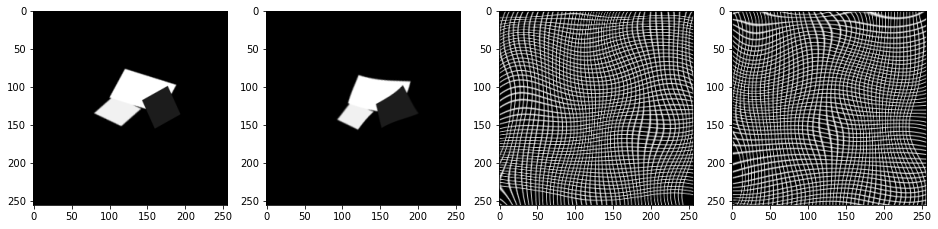

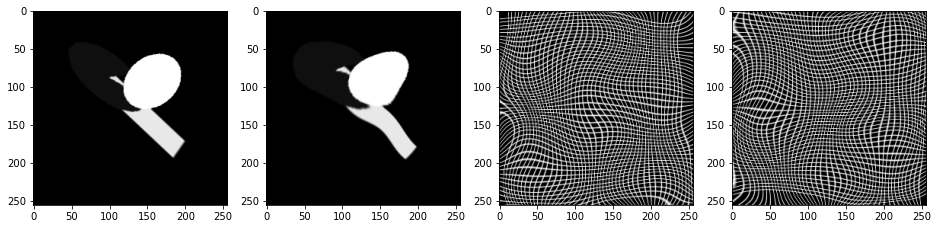

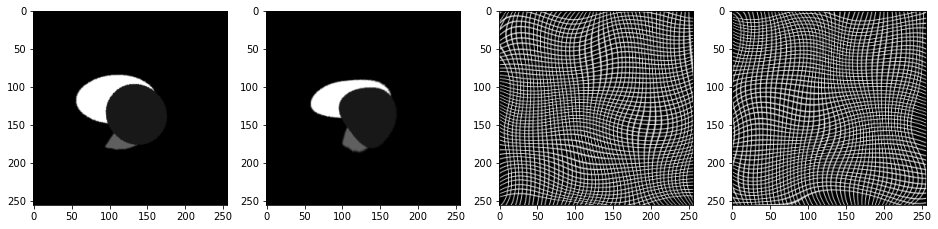

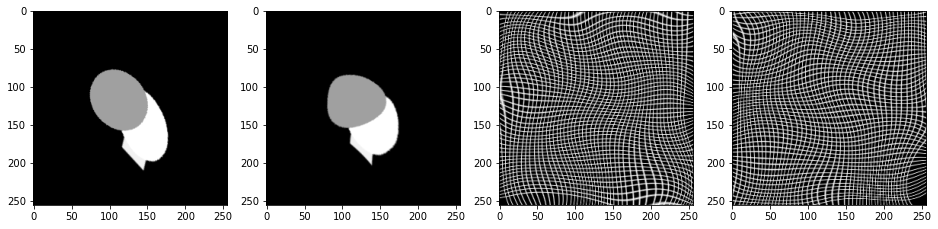

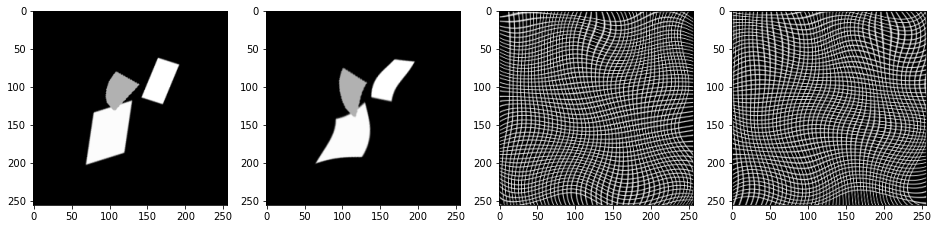

In [14]:
num_samples = 5
for i in choice(moved_imgs.shape[0],num_samples,False):
    img = moved_imgs[i]
    u = disp_fields[i]
    #print('number of folding =',count_fold_fn(tf.expand_dims(u,axis=0)))
    ex_img = np.expand_dims(img,0)
    ex_u = np.expand_dims(u,0)
    warp_img = dense_image_warp(ex_img,ex_u)
    plt.figure(figsize=(16,4))
    plt.subplot(141)
    plt.imshow(img,cmap='gray',vmax=1)
    plt.subplot(142)
    plt.imshow(tf.squeeze(warp_img),cmap='gray',vmax=1)
    plt.subplot(143)
    grid_warp(u)
    plt.subplot(144)
    grid_warp(-u)
    plt.show()

In [10]:
data_set = np.concatenate([moved_imgs,fixed_imgs],axis=-1)
data_set.shape

(550, 256, 256, 2)

In [12]:
np.save('550m2f_Diffeomorphic_Deform.npy',data_set)